# Full - Text Search with Elasticsearch
Project setup will maden by docker. Project is about "company wants to full-text search on own data with elasticsearch" Project is going to follow these steps:
1. Elasticsearch Installation
2. Data Understanding / Preparing
3. Import Data to Elasticsearch

## Elasticsearch Installation
Running docker desktop:

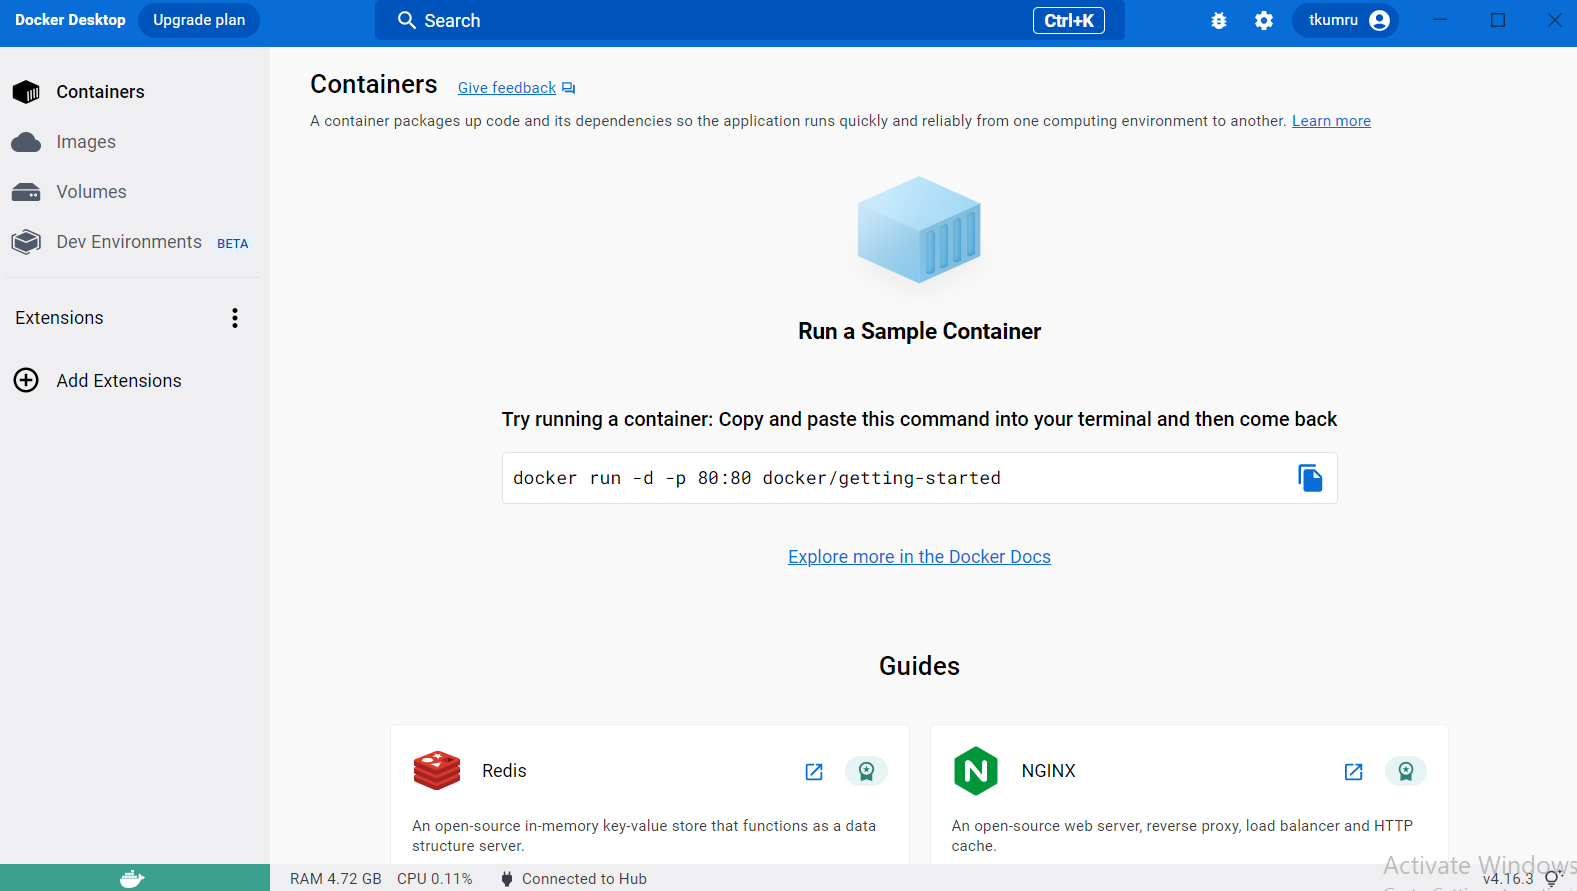

Prepare to docker-compose.yml file:
```
version: '3'

services:
  elasticsearch:
    image: docker.elastic.co/elasticsearch/elasticsearch:7.9.0
    container_name: elasticsearch
    environment:
      - node.name=elasticsearch
      - cluster.name=Atscale-ELK-Cluster
      - discovery.seed_hosts=elasticsearch
      - cluster.initial_master_nodes=elasticsearch
      - bootstrap.memory_lock=true
      - "ES_JAVA_OPTS=-Xms512m -Xmx512m"
    ulimits:
      memlock:
        soft: -1
        hard: -1
    volumes:
      - elk-node-data:/usr/share/elasticsearch/data
    ports:
      - 9200:9200
    networks:
      - elastic

  kibana:
    image: docker.elastic.co/kibana/kibana:7.9.0
    depends_on:
      - elasticsearch
    container_name: kibana
    ports:
      - 5601:5601
    environment:
      ELASTICSEARCH_URL: http://elasticsearch:9200
      ELASTICSEARCH_HOSTS: http://elasticsearch:9200
    networks:
      - elastic
   
  logstash:
    image: docker.elastic.co/logstash/logstash:7.9.0
    depends_on:
      - elasticsearch
      - kibana
    container_name: logstash
    volumes:
      - logstash-data:/usr/share/logstash
    networks:
      - elastic
      
volumes:
  elk-node-data:
    driver: local
  logstash-data:
    driver: local
    
networks:
  elastic:
    driver: bridge
```
Before build docker compose, set to virtual memory at least 262144:
```
wsl -d docker-desktop
sysctl -w vm.max_map_count=262144
```
Build docker compose:

In [1]:
!docker-compose up -d

Network full_text_search_with_elasticsearch_elastic  Creating
Network full_text_search_with_elasticsearch_elastic  Created
Volume "full_text_search_with_elasticsearch_elk-node-data"  Creating
Volume "full_text_search_with_elasticsearch_elk-node-data"  Created
Volume "full_text_search_with_elasticsearch_logstash-data"  Creating
Volume "full_text_search_with_elasticsearch_logstash-data"  Created
Container elasticsearch  Creating
Container elasticsearch  Created
Container kibana  Creating
Container kibana  Created
Container logstash  Creating
Container logstash  Created
Container elasticsearch  Starting
Container elasticsearch  Started
Container kibana  Starting
Container kibana  Started
Container logstash  Starting
Container logstash  Started


In [2]:
!docker-compose ps

NAME                IMAGE                                                 COMMAND                  SERVICE             CREATED             STATUS              PORTS
elasticsearch       docker.elastic.co/elasticsearch/elasticsearch:7.9.0   "/tini -- /usr/localâ€¦"   elasticsearch       20 seconds ago      Up 16 seconds       0.0.0.0:9200->9200/tcp, 9300/tcp
kibana              docker.elastic.co/kibana/kibana:7.9.0                 "/usr/local/bin/dumbâ€¦"   kibana              20 seconds ago      Up 15 seconds       0.0.0.0:5601->5601/tcp
logstash            docker.elastic.co/logstash/logstash:7.9.0             "/usr/local/bin/dockâ€¦"   logstash            20 seconds ago      Up 15 seconds       5044/tcp, 9600/tcp


Let's see the Kibana UI:
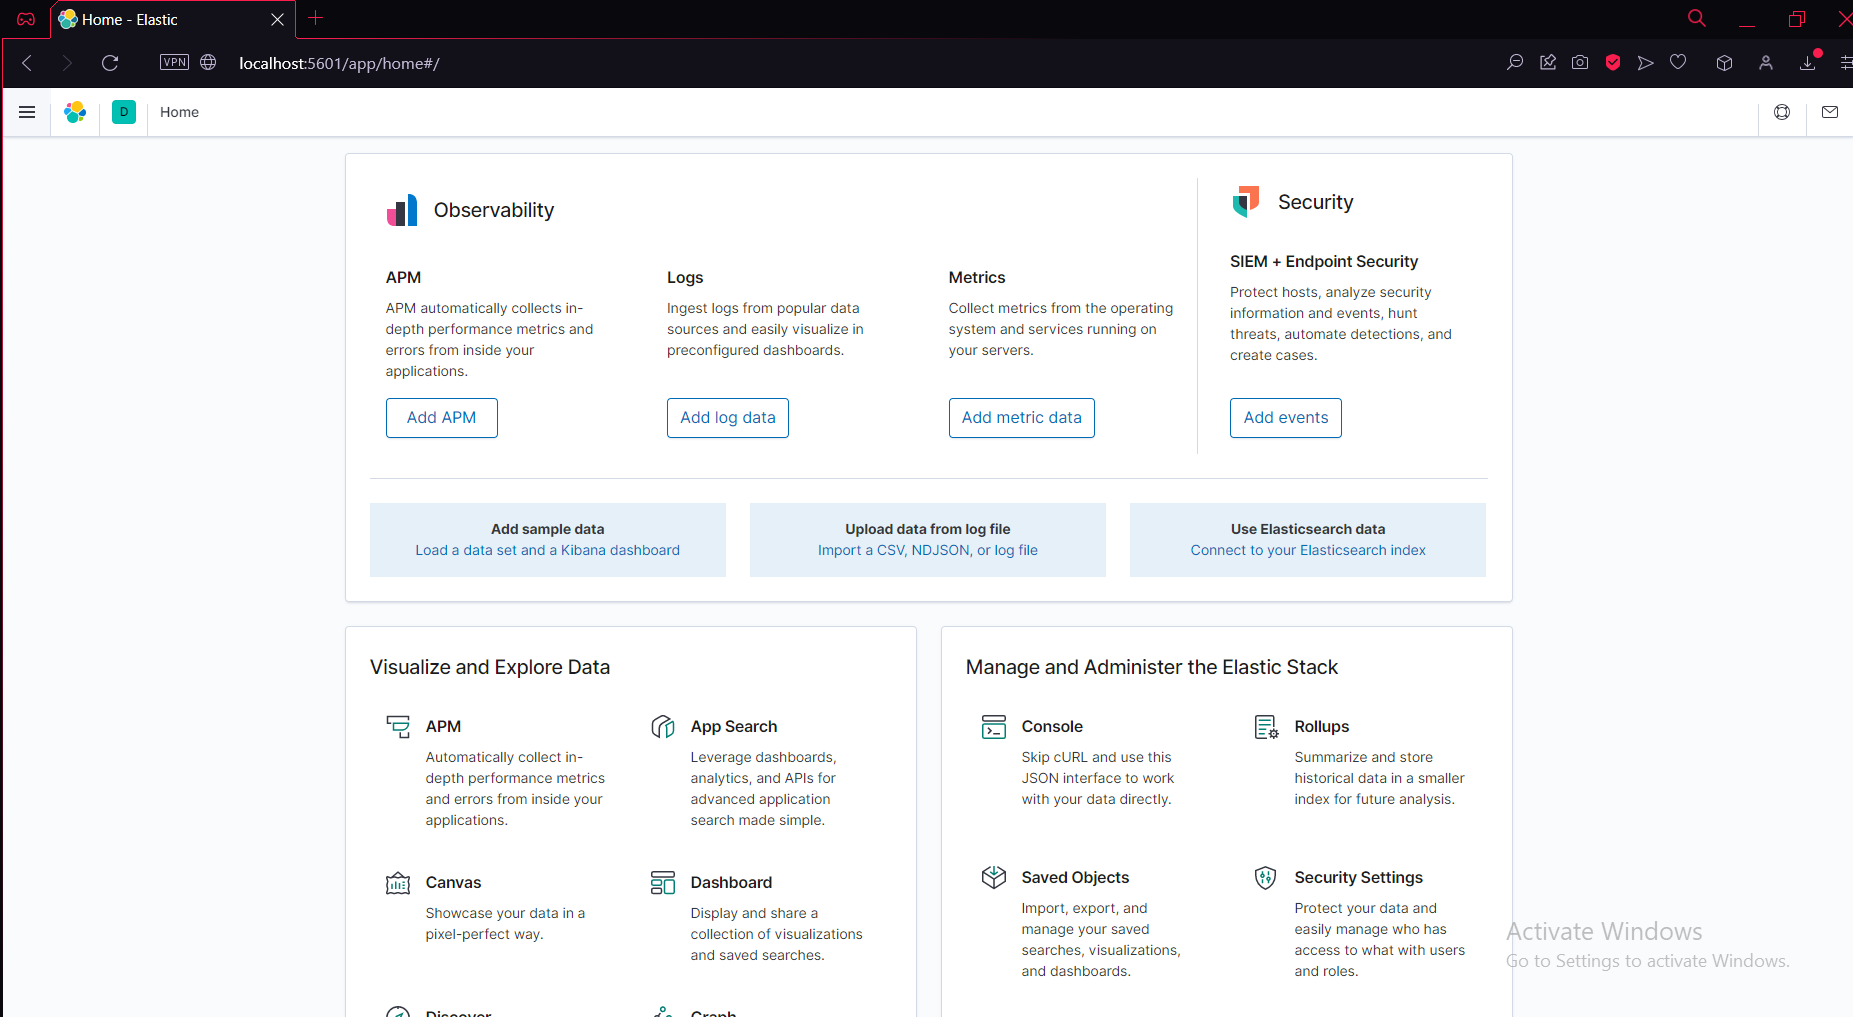
## Data Understanding / Preparing

In [3]:
# !pip install elasticsearch==7.14.0

In [4]:
import pandas as pd

df = pd.read_csv("datasets/products.csv")

In [5]:
df.head()

,productId,productCategoryId,productName,productDescription,productPrice,productImage
0,1,2,Quest Q64 10 FT. x 10 FT. Slant Leg Instant U,NaN,59.98,http://images.acmesports.sports/Quest+Q64+10+F...
1,2,2,Under Armour Men's Highlight MC Football Clea,NaN,129.99,http://images.acmesports.sports/Under+Armour+M...
2,3,2,Under Armour Men's Renegade D Mid Football Cl,NaN,89.99,http://images.acmesports.sports/Under+Armour+M...
3,4,2,Under Armour Men's Renegade D Mid Football Cl,NaN,89.99,http://images.acmesports.sports/Under+Armour+M...
4,5,2,Riddell Youth Revolution Speed Custom Footbal,NaN,199.99,http://images.acmesports.sports/Riddell+Youth+...


In [6]:
df.count()

productId             1345
productCategoryId     1345
productName           1345
productDescription       0
productPrice          1345
productImage          1345
dtype: int64

In [8]:
df.shape

(1345, 6)

In [9]:
df.dtypes

productId               int64
productCategoryId       int64
productName            object
productDescription    float64
productPrice          float64
productImage           object
dtype: object

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1345 entries, 0 to 1344
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   productId           1345 non-null   int64  
 1   productCategoryId   1345 non-null   int64  
 2   productName         1345 non-null   object 
 3   productDescription  0 non-null      float64
 4   productPrice        1345 non-null   float64
 5   productImage        1345 non-null   object 
dtypes: float64(2), int64(2), object(2)
memory usage: 63.2+ KB


In [19]:
df.isnull().sum()

productId                0
productCategoryId        0
productName              0
productDescription    1345
productPrice             0
productImage             0
dtype: int64

In [20]:
df = df.drop("productDescription", axis=1)

## Import Data to Elasticsearch

In [11]:
from elasticsearch import Elasticsearch, helpers

In [12]:
elas = Elasticsearch("localhost:9200")

In [21]:
body = {
    "mappings": {
        "properties": {
            "productId": { "type": "integer" },
            "productCategoryId": { "type": "integer" },
            "productName": { "type": "keyword" },
            "productPrice": { "type": "float" },
            "productImage": { "type": "text" }
        }
    }
}

In [23]:
try: 
    elas.indices.delete("products")
except:
    elas.indices.create("products", body=body)

In [24]:
def to_elasticsearch(df: pd.DataFrame, index_name: str):
    for row in df.itertuples():
        yield {
            "_index": index_name,
            "_id": row.Index,
            "_source": {
                "productId":  row.productId,  
                "productCategoryId": row.productCategoryId, 
                "productName": row.productName,
                "productPrice": row.productPrice,
                "productImage": row.productImage
            }
        }

In [25]:
helpers.bulk(elas, to_elasticsearch(df, "products"), raise_on_error=False)

(1345, [])

Let's get productName which contains **Football**:

In [38]:
result = elas.sql.query(body={
    "query": "SELECT * FROM products WHERE productName LIKE '%Football%'"
})

In [49]:
columns = [column["name"] for column in result["columns"]]

In [50]:
rows = result["rows"]

In [51]:
result_df = pd.DataFrame(rows, columns=columns)

In [52]:
result_df

,productCategoryId,productId,productImage,productName,productPrice
0,2,2,http://images.acmesports.sports/Under+Armour+M...,Under Armour Men's Highlight MC Football Clea,129.990005
1,2,3,http://images.acmesports.sports/Under+Armour+M...,Under Armour Men's Renegade D Mid Football Cl,89.989998
2,2,4,http://images.acmesports.sports/Under+Armour+M...,Under Armour Men's Renegade D Mid Football Cl,89.989998
3,2,6,http://images.acmesports.sports/Jordan+Men%27s...,Jordan Men's VI Retro TD Football Cleat,134.990005
4,2,7,http://images.acmesports.sports/Schutt+Youth+R...,Schutt Youth Recruit Hybrid Custom Football H,99.989998
...,...,...,...,...,...
70,54,1224,http://images.acmesports.sports/Schutt+XV+Flex...,Schutt XV Flex Skill Shield Football Shoulder,179.990005
71,59,1325,http://images.acmesports.sports/Nike+Johnny+Fo...,Nike Johnny Football Camo Graphic T-Shirt,30.000000
72,59,1327,http://images.acmesports.sports/Nike+Johnny+Fo...,Nike Johnny Football Camo Jersey T-Shirt,30.000000
73,59,1329,http://images.acmesports.sports/Nike+Men%27s+C...,Nike Men's Cleveland Browns Johnny Football O,28.000000


In [53]:
!docker-compose down

Container logstash  Stopping
Container logstash  Stopping
Container logstash  Stopped
Container logstash  Removing
Container logstash  Removed
Container kibana  Stopping
Container kibana  Stopping
Container kibana  Stopped
Container kibana  Removing
Container kibana  Removed
Container elasticsearch  Stopping
Container elasticsearch  Stopping
Container elasticsearch  Stopped
Container elasticsearch  Removing
Container elasticsearch  Removed
Network full_text_search_with_elasticsearch_elastic  Removing
Network full_text_search_with_elasticsearch_elastic  Removed
